## DNN Model for the classification of cancer types

## DNN Model (without_outliers)

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Bidirectional, Flatten, GRU, Reshape
from keras.optimizers import SGD, Adam, Adamax, RMSprop, Adagrad
from keras.metrics import AUC, Accuracy, CategoricalAccuracy, sparse_categorical_accuracy
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, roc_curve, make_scorer, auc
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error, classification_report, confusion_matrix
from tensorflow.keras import layers, activations
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.multioutput import MultiOutputClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras_tuner as kt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from statistics import mean
from scikeras.wrappers import KerasClassifier
import imblearn
from collections import Counter
from matplotlib import pyplot
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
import keras.backend as K
import pickle
import colorcet as cc
from skopt import BayesSearchCV

### Useful functions

In [2]:
def evaluate_multiclass_classification_model(model, X_train, y_train, X_test, y_test):    
    y_pred = model.predict(X_test)
    metrics = {}
    #metrics['AUC'] = roc_auc_score(y_test, y_pred, multi_class='ovr')
    metrics['F1-score'] = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    metrics['RMSE'] = np.sqrt(mean_squared_error(y_test, y_pred))
    metrics['Precisión'] = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    metrics['Recall'] = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    metrics['MAPE'] = mean_absolute_percentage_error(y_test, y_pred)
    metrics['RMSLE'] = np.sqrt(mean_squared_log_error(y_test, y_pred))
    metrics['Accuracy'] = accuracy_score(y_test, y_pred)

    for metric, value in metrics.items():
        print(metric + ':', value)

    print(classification_report(y_test, y_pred))

def evaluate_roc_classification_model(model, X_train, y_train, X_test, y_test):
    y_train_proba = model.predict_proba(X_train)
    y_test_proba = model.predict_proba(X_test)

    fpr_train = {}
    tpr_train = {}
    roc_auc_train = {}
    fpr_test = {}
    tpr_test = {}
    roc_auc_test = {}

    num_classes = len(np.unique(y_test, return_counts=False))

    for i in range(num_classes):
        fpr_train[i], tpr_train[i], _ = roc_curve(y_train == i, y_train_proba[:, i])
        roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

    # Calcular la curva ROC para cada clase en el conjunto de prueba
    for i in range(num_classes):
        fpr_test[i], tpr_test[i], _ = roc_curve(y_test == i, y_test_proba[:, i])
        roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])


    results = model.best_estimator_.evals_result_
    epochs = 10
    if (type(model.best_estimator_).__name__ == "LGBMClassifier"):
        epochs = len(results['training']['multi_logloss'])
    elif (type(model.best_estimator_).__name__ == "XGBClassifier"):
        epochs = len(results['validation_0']['merror'])
    x_axis = range(0, epochs)
    colors = colors = np.random.rand(num_classes, 3) 
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    # plot auc
    for i in range(num_classes):
        ax[0].plot(fpr_train[i], tpr_train[i], color=colors[i], lw=2,
                label='ROC curve (train) - Class {0} (AUC = {1:.2f})'.format(i, roc_auc_train[i]))
        ax[0].plot(fpr_test[i], tpr_test[i], color=colors[i], linestyle='--', lw=2,
                label='ROC curve (test) - Class {0} (AUC = {1:.2f})'.format(i, roc_auc_test[i]))
    
    ax[0].plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver Operating Characteristic (ROC)')
    #ax[0].legend(loc="lower right")
    if (type(model.best_estimator_).__name__ == 'LGBMClassifier'):        
        ax[1].plot(x_axis, results['training']['multi_logloss'], label='Train')
        ax[1].plot(x_axis, results['valid_1']['multi_logloss'], label='Test')
    elif (type(model.best_estimator_).__name__ == "XGBClassifier"):
        ax[1].plot(x_axis, results['validation_0']['merror'], label='Train')
        ax[1].plot(x_axis, results['validation_1']['merror'], label='Test')
    ax[1].legend()
    ax[1].set_title('XGBoost Classification Error')
    ax[1].set_ylabel('Classification Error')
    ax[1].set_xlabel('N estimators')
    plt.show()
    plt.tight_layout()

def show_aoc(model, X_test, y_test):
    # Obtener las probabilidades de predicción para cada clase
    y_prob = model.predict_proba(X_test)

    # Crear un array binario para cada clase
    y_true = np.zeros_like(y_prob)
    y_true[np.arange(len(y_true)), y_test] = 1

    # Calcular el AUC para cada clase
    auc_scores = []
    for i in range(len(model.classes_)):
        auc = roc_auc_score(y_true[:, i], y_prob[:, i])
        auc_scores.append(auc)

    # Calcular el promedio de los AUC
    mean_auc = np.mean(auc_scores)

    # Imprimir los resultados
    for i in range(len(model.classes_)):
        print(f"AUC Clase {i}: {auc_scores[i]}")
    print(f"Promedio AUC: {mean_auc}")  

def graph_importance_xgb(model, X_test):    
    model.get_booster().feature_names = X_test.columns.to_list()        
    # Create the feature importances plot
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    # plot importances with feature weight
    xgb.plot_importance(
        booster=model, 
        importance_type='weight',
        title='Feature Weight',
        show_values=False,
        height=0.5,
        ax=ax[0],
    )
    # plot importances with split mean gain
    xgb.plot_importance(
        booster=model,
        importance_type='gain',
        title='Split Mean Gain',
        show_values=False,
        height=0.5,
        ax=ax[1]
    )
    # plot importances with sample coverage
    xgb.plot_importance(
        model,
        importance_type='cover',
        title='Sample Coverage',
        show_values=False,
        height=0.5,
        ax=ax[2]
    )
    plt.tight_layout()
    plt.show()

def graph_importance_lgb(model):   
        
    # Create the feature importances plot
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    # plot importances with feature weight
    lgb.plot_importance(
        booster=model, 
        importance_type='split',
        title='Feature split',
        height=0.5,
        ax=ax[0],
    )
    # plot importances with split mean gain
    lgb.plot_importance(
        booster=model,
        importance_type='gain',
        title='Split Mean Gain',
        height=0.5,
        ax=ax[1]
    )
    plt.tight_layout()
    plt.show()

def multiclass_confusion_matrix(model, X_test, y_test):  
    y_pred = model.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(confusion_mat, annot=True, cmap='Blues')

## Load Data

In [23]:
#load dataframe
#outlier_folder = "with_outliers"
outlier_folder = "without_outliers"
df_genes_labels_file = f'Data/{outlier_folder}/df_genes_labels_without_outliers_tmm.pkl'

if os.path.exists(df_genes_labels_file):
    df_genes_labels = pd.read_pickle(df_genes_labels_file)
else:
    raise Exception("You need to run the notebook \"PrepareDataExploratoryAnalysis\".")

df_genes_labels_file = f'Data/{outlier_folder}/df_expression_data_reg_Elastic_net_tmm_264_features.pkl'
if os.path.exists(df_genes_labels_file):
    df_genes_labels_selected = pd.read_pickle(df_genes_labels_file)
else:
    raise Exception("You need to run the notebook \"ReduceDimensionality\".")

labels = df_genes_labels.iloc[:, 5441:5442]

df_genes_labels_selected['Patient_group'] = labels

print(f'Number of types of cancer: \n {len(labels.value_counts())} \n')
print(f'Total number of samples: \n {len(labels)} \n')
print(f'Number of features: \n {len(df_genes_labels_selected.columns) -1} \n')
print(f'Number of samples by type of cancer: \n {labels.value_counts()} \n')

Number of types of cancer: 
 19 

Total number of samples: 
 2307 

Number of features: 
 266 

Number of samples by type of cancer: 
 Patient_group
0                700
2                510
7                141
1                132
3                125
5                101
4                 93
11                85
8                 84
6                 68
10                51
13                39
16                35
9                 31
17                28
18                28
12                23
15                20
14                13
Name: count, dtype: int64 



In [24]:
# Remove cancer types with less than 51 samples
counts = df_genes_labels_selected['Patient_group'].value_counts()
categories_to_maintain = counts[counts >= 51].index
df_genes_labels_selected = df_genes_labels_selected[df_genes_labels_selected['Patient_group'].isin(categories_to_maintain)]
counts = df_genes_labels_selected['Patient_group'].value_counts()
print(f'Number of types of cancer: \n {len(counts)} \n')
print(f'Number of samples by type of cancer: \n {counts} \n')

Number of types of cancer: 
 11 

Number of samples by type of cancer: 
 Patient_group
0     700
2     510
7     141
1     132
3     125
5     101
4      93
11     85
8      84
6      68
10     51
Name: count, dtype: int64 



In [25]:
labels = df_genes_labels_selected['Patient_group']
df_genes_labels_selected = df_genes_labels_selected.iloc[:,:-1]
X_train, X_test, y_train, y_test = train_test_split(df_genes_labels_selected, labels, test_size=0.2, random_state=42, shuffle=True)

print(f'Cantidad de elementos por clase en TRAIN: \n {y_train.value_counts()} \n')
print(f'Cantidad de elementos por clase en TEST: \n {y_test.value_counts()}')

Cantidad de elementos por clase en TRAIN: 
 Patient_group
0     558
2     406
7     119
1     106
3      96
5      82
4      76
11     71
8      65
6      52
10     41
Name: count, dtype: int64 

Cantidad de elementos por clase en TEST: 
 Patient_group
0     142
2     104
3      29
1      26
7      22
5      19
8      19
4      17
6      16
11     14
10     10
Name: count, dtype: int64


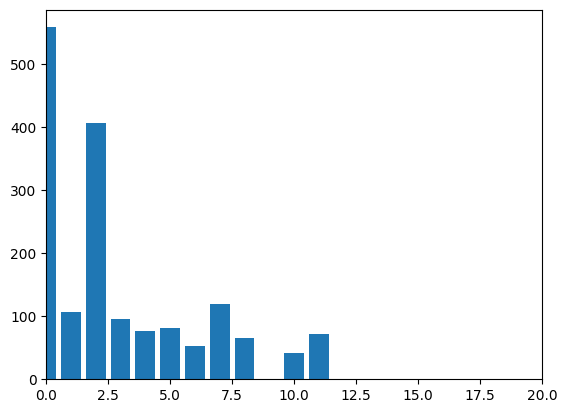

In [26]:
# summarize distribution
counter = Counter(y_train)
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
plt.xlim(0, 20)
pyplot.show()

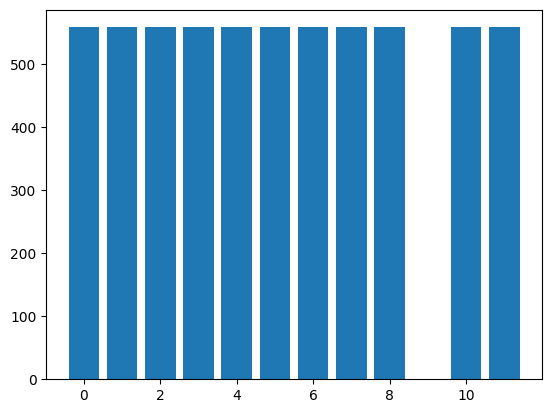

In [27]:
X, y = SMOTE(k_neighbors=2).fit_resample(X_train, y_train)
# summarize distribution
counter = Counter(y)
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

## MODEL SVC

In [30]:
svc_file = 'Data/models/best_multiclass_SVC_tmm_264_Elast.h5'
np.int = np.int64

if os.path.exists(svc_file):
    with open(svc_file, 'rb') as f:
        svc_model = pickle.load(f)
else:
    param_space = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']        
    }

    #svc = make_pipeline(StandardScaler(), svm.SVC())
    svc = svm.SVC()

    #grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1)
    opt = BayesSearchCV(svc, param_space, n_iter=30, cv=5, n_jobs=-1)
    svc_model = opt.fit(X, y)

    pickle.dump(svc_model, open(svc_file, "wb"))

    best_params = opt.best_params_
    best_model = opt.best_estimator_

    print(best_model.get_params)
    print(best_params.items())

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objectiv

<bound method BaseEstimator.get_params of SVC(C=10.0, gamma='auto')>
odict_items([('C', 10.0), ('gamma', 'auto'), ('kernel', 'rbf')])


----METRICS SVC
F1-score: 0.5256466805618463
RMSE: 3.2218601420793576
Precisión: 0.5840021477046826
Recall: 0.5909090909090909
MAPE: 506385604034481.94
RMSLE: 0.8019107748396782
Accuracy: 0.5909090909090909
              precision    recall  f1-score   support

           0       0.68      0.85      0.75       142
           1       0.69      0.35      0.46        26
           2       0.49      0.88      0.63       104
           3       1.00      0.10      0.19        29
           4       0.69      0.53      0.60        17
           5       0.86      0.32      0.46        19
           6       0.00      0.00      0.00        16
           7       0.54      0.32      0.40        22
           8       0.50      0.05      0.10        19
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        14

    accuracy                           0.59       418
   macro avg       0.50      0.31      0.33       418
weighted avg       0.58      0.59  

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

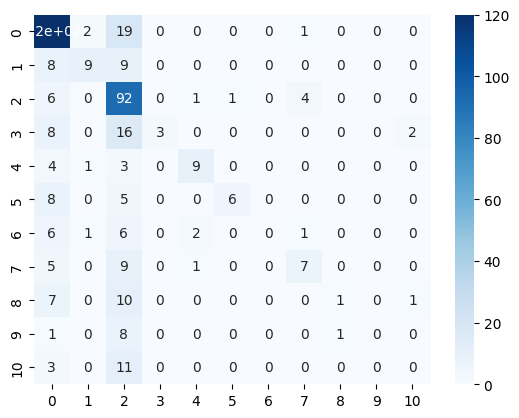

In [31]:
print("----METRICS SVC")
if not os.path.exists(svc_file):
    pickle.dump(best_model, open(best_model, "wb"))
evaluate_multiclass_classification_model(best_model, X, y, X_test, y_test)
#graph_importance_xgb(best_model.best_estimator_, X_test)
multiclass_confusion_matrix(best_model, X_test, y_test)

## MODEL Random Forest

In [32]:
rforest_file = 'Data/models/best_multiclass_RForest_tmm_325-RFE_class.h5'
np.int = np.int64

if os.path.exists(rforest_file):
    with open(svc_file, 'rb') as f:
        rforest_model = pickle.load(f)
else:
    param_space = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
    }

    rf = RandomForestClassifier()

    opt = BayesSearchCV(rf, param_space, n_iter=30, cv=5, n_jobs=-1)
    rforest_model = opt.fit(X, y)

    pickle.dump(rforest_model, open(rforest_file, "wb"))

    best_params = opt.best_params_
    best_model = opt.best_estimator_

    print(best_model.get_params)
    print(best_params.items())

----METRICS SVC
F1-score: 0.5256466805618463
RMSE: 3.2218601420793576
Precisión: 0.5840021477046826
Recall: 0.5909090909090909
MAPE: 506385604034481.94
RMSLE: 0.8019107748396782
Accuracy: 0.5909090909090909
              precision    recall  f1-score   support

           0       0.68      0.85      0.75       142
           1       0.69      0.35      0.46        26
           2       0.49      0.88      0.63       104
           3       1.00      0.10      0.19        29
           4       0.69      0.53      0.60        17
           5       0.86      0.32      0.46        19
           6       0.00      0.00      0.00        16
           7       0.54      0.32      0.40        22
           8       0.50      0.05      0.10        19
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        14

    accuracy                           0.59       418
   macro avg       0.50      0.31      0.33       418
weighted avg       0.58      0.59  

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

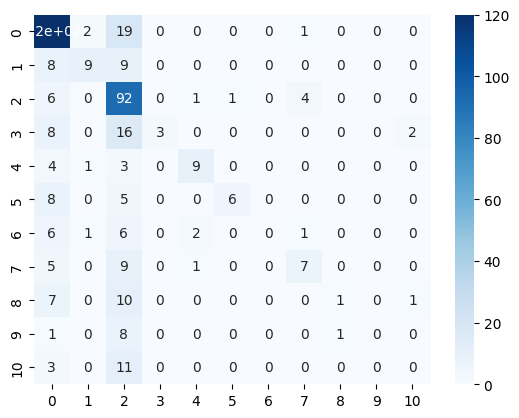

In [33]:
print("----METRICS SVC")
if not os.path.exists(rforest_file):
    pickle.dump(best_model, open(best_model, "wb"))
evaluate_multiclass_classification_model(best_model, X, y, X_test, y_test)
#graph_importance_xgb(best_model.best_estimator_, X_test)
multiclass_confusion_matrix(best_model, X_test, y_test)

## MODEL XGBoost

In [34]:
np.unique(y_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11], dtype=int64)

In [35]:
# The classifier expects classes numbered from 0 to 10. I will rename all classes numbered 11 by 9.
old_class = 11
new_class = 9

y = np.where(y == old_class, new_class, y)
y_test = np.where(y_test == old_class, new_class, y_test)

print(np.unique(y_test))

[ 0  1  2  3  4  5  6  7  8  9 10]


In [38]:
#https://medium.com/@danielflor/using-xgboost-with-gpu-in-google-collab-4961999555f4
#https://towardsdatascience.com/running-xgboost-on-google-colab-free-gpu-a-case-study-841c90fef101

xgb_file = 'Data/models/best_multiclass_XGB_tmm_266-Elast.h5'

if os.path.exists(xgb_file):
    with open(xgb_file, 'rb') as f:
        xgb_model = pickle.load(f)
else:
    seed = 42
    xgb_clf = XGBClassifier(objective='multi:softmax', eval_metric=["merror"], random_state=seed)
    
    search_space = [
                {"n_estimators": [100, 200, 300, 600],
                 "max_depth": [3, 6, 9],
                 "learning_rate": [0.001, 0.01, 0.1, 0.2],
                 "gamma": [0.5, 1, 1.5, 2, 5],
                 "subsample": [0.6, 0.8, 1.0],
                 "colsample_bytree": [0.6, 0.8, 1.0]
                 }
                ]

    scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
    }

    # create the Kfold object
    num_folds = 3
    kfold = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    # create the grid search object   
    n_iter=50
    random_search = RandomizedSearchCV(
        estimator=xgb_clf, 
        param_distributions=search_space,
        cv=kfold,
        n_jobs=-1,
        n_iter=n_iter,
        refit="AUC",
        scoring=scoring,        
        verbose=1
    ) 

    # fit grid search
    eval_set = [(X, y), (X_test, y_test)]
    eval_metric = ["merror"]
    xgb_model = random_search.fit(X, y, eval_set = eval_set)

    pickle.dump(xgb_model, open(xgb_file, "wb"))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


[0]	validation_0-merror:0.09075	validation_1-merror:0.65072
[1]	validation_0-merror:0.03617	validation_1-merror:0.60048
[2]	validation_0-merror:0.02167	validation_1-merror:0.58852
[3]	validation_0-merror:0.01450	validation_1-merror:0.56220
[4]	validation_0-merror:0.01026	validation_1-merror:0.53828
[5]	validation_0-merror:0.00945	validation_1-merror:0.52632
[6]	validation_0-merror:0.00782	validation_1-merror:0.51435
[7]	validation_0-merror:0.00603	validation_1-merror:0.48804
[8]	validation_0-merror:0.00440	validation_1-merror:0.49282
[9]	validation_0-merror:0.00358	validation_1-merror:0.46651
[10]	validation_0-merror:0.00277	validation_1-merror:0.45694
[11]	validation_0-merror:0.00244	validation_1-merror:0.45933
[12]	validation_0-merror:0.00244	validation_1-merror:0.45215
[13]	validation_0-merror:0.00212	validation_1-merror:0.45215
[14]	validation_0-merror:0.00147	validation_1-merror:0.44258
[15]	validation_0-merror:0.00114	validation_1-merror:0.44498
[16]	validation_0-merror:0.00081	v

----METRICS XGBoost
F1-score: 0.5615438804980075
RMSE: 2.9338806217009483
Precisión: 0.5617140116661647
Recall: 0.5909090909090909
MAPE: 1379092708859864.8
RMSLE: 0.8024163680709697
Accuracy: 0.5909090909090909
              precision    recall  f1-score   support

           0       0.67      0.76      0.71       142
           1       0.52      0.50      0.51        26
           2       0.61      0.77      0.68       104
           3       0.58      0.24      0.34        29
           4       0.46      0.71      0.56        17
           5       0.58      0.37      0.45        19
           6       0.40      0.12      0.19        16
           7       0.50      0.55      0.52        22
           8       0.33      0.21      0.26        19
           9       0.00      0.00      0.00        14
          10       0.40      0.20      0.27        10

    accuracy                           0.59       418
   macro avg       0.46      0.40      0.41       418
weighted avg       0.56      0.

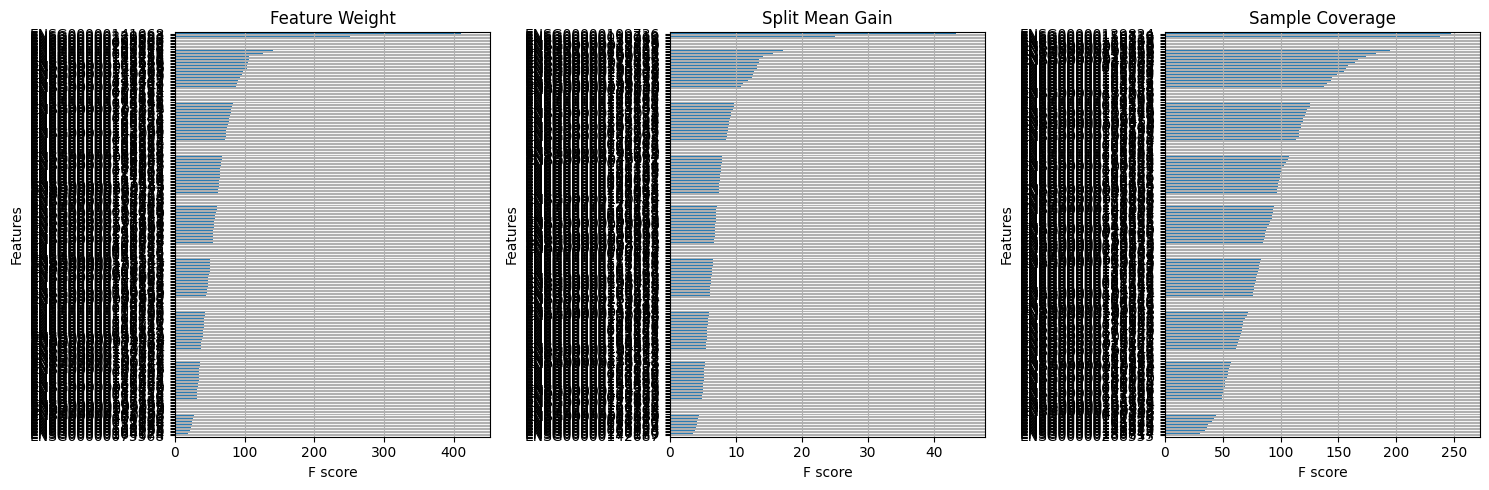

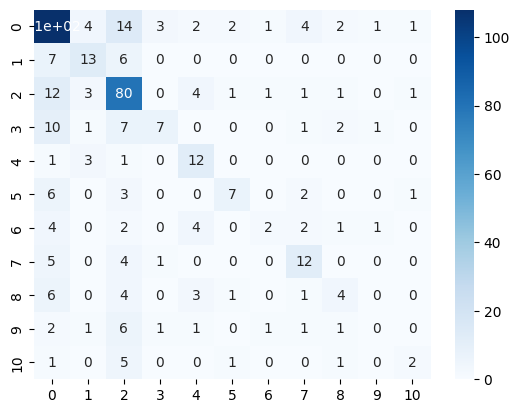

In [39]:
print("----METRICS XGBoost")
if not os.path.exists(xgb_file):
    pickle.dump(xgb_model, open(xgb_file, "wb"))
evaluate_multiclass_classification_model(xgb_model, X, y, X_test, y_test)
graph_importance_xgb(xgb_model.best_estimator_, X_test)
multiclass_confusion_matrix(xgb_model, X_test, y_test)

## MODEL LightGBM

In [42]:
lgbm_file = 'Data/models/best_multiclass_LGBM_tmm_266-Elast.h5'

if os.path.exists(lgbm_file):
    with open(lgbm_file, 'rb') as f:
        lgb_model = pickle.load(f)
else:
    seed = 42
    lgbm_clf = LGBMClassifier(objective='multiclass', metric='multi_logloss', num_classes=11, random_state=seed)
    
    search_space = [
                {"max_depth": [3, 6, 9, 12],
                "learning_rate": [0.1, 0.01, 0.001, 0.0001],
                "num_leaves": [31, 63, 127],
                "n_estimators": [100, 200, 300, 600],
                 }
                ]

    scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
    }

    # create the Kfold object
    num_folds = 3
    kfold = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    # create the grid search object   
    n_iter=50
    grid = RandomizedSearchCV(
        estimator=lgbm_clf, 
        param_distributions=search_space,
        cv=kfold,
        n_jobs=-1,
        n_iter=n_iter,
        refit="AUC",
        scoring=scoring,
        verbose=1
    ) 

    # fit grid search
    eval_set = [(X, y), (X_test, y_test)]
    eval_metric = ["multi_logloss"]
    lgbm_model = grid.fit(X, y, eval_set = eval_set, eval_metric = eval_metric)

    pickle.dump(lgbm_model, open(lgbm_file, "wb"))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67830
[LightGBM] [Info] Number of data points in the train set: 6138, number of used features: 266
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

----METRICS LightGBM
F1-score: 0.5322611454701742
RMSE: 3.238524089382687
Precisión: 0.5402567416627263
Recall: 0.5382775119617225
MAPE: 2402638078716795.5
RMSLE: 0.8477533859520826
Accuracy: 0.5382775119617225
              precision    recall  f1-score   support

           0       0.70      0.63      0.67       142
           1       0.48      0.58      0.53        26
           2       0.59      0.70      0.64       104
           3       0.38      0.21      0.27        29
           4       0.33      0.47      0.39        17
           5       0.35      0.37      0.36        19
           6       0.57      0.25      0.35        16
           7       0.48      0.59      0.53        22
           8       0.26      0.26      0.26        19
           9       0.21      0.21      0.21        14
          10       0.12      0.10      0.11        10

    accuracy                           0.54       418
   macro avg       0.41      0.40      0.39       418
weighted avg       0.54      0.

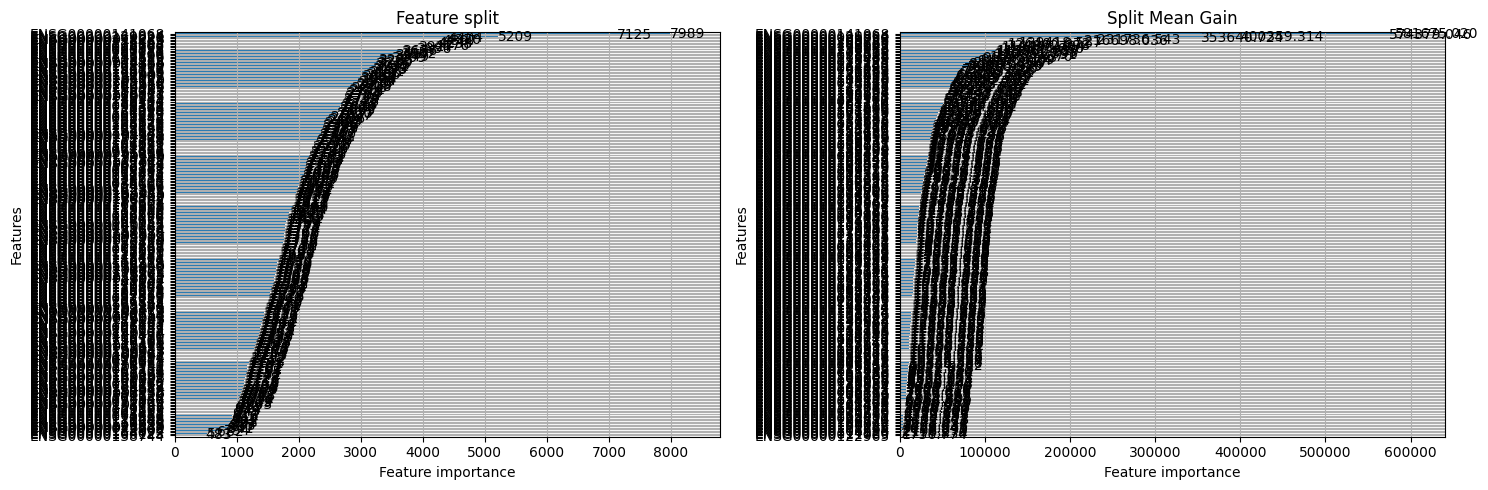

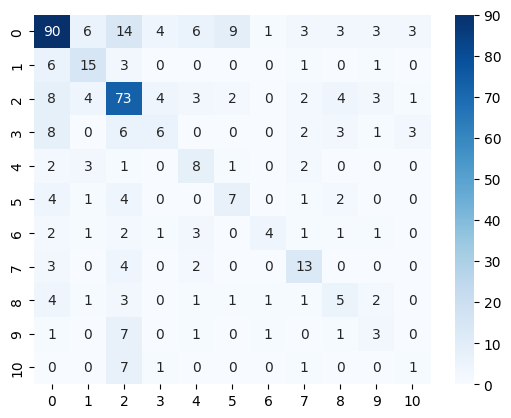

In [43]:
print("----METRICS LightGBM")
#lgbm_model = best_model.best_estimator_
if not os.path.exists(lgbm_file):
    pickle.dump(lgb_model, open(xgb_file, "wb"))
evaluate_multiclass_classification_model(lgbm_model, X, y, X_test, y_test)
graph_importance_lgb(lgbm_model.best_estimator_)
multiclass_confusion_matrix(lgbm_model, X_test, y_test)